## Importing necessary libraries

In [1]:
import numpy as np
import random
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt

## Extracting data from csv files

In [2]:
DATA_PATH = os.getcwd()+ '/data/'
IMAGES_PATH = os.getcwd()+ '/images/'
CRASH_REWARD = -1000
AWAY_REWARD = -500
BEST_REWARD = 1000
AVERAGE_EPISODE_COUNT = 40

In [3]:
def read_data(path):
    
    df = pd.read_csv(path)
    data = df.to_numpy().reshape((len(df),))
    return data

In [4]:
def get_concat_average(episodic_rewards_arr):
    
    average_episodic_rewards = []
    episode_reward_list = [episodic_rewards_arr[0]]

    for episodic_reward in episodic_rewards_arr:
        average_episodic_rewards.append(np.mean(episode_reward_list[-AVERAGE_EPISODE_COUNT:]))
        episode_reward_list.append(episodic_reward)

    average_episodic_rewards = np.array(average_episodic_rewards)
    
    return average_episodic_rewards

In [5]:
def get_data(training_names):

    if len(training_names) == 1:
        
        training_name = training_names[0]
        
        rewards = read_data(DATA_PATH + training_names[0] + '/rewards.csv')
        steps = read_data(DATA_PATH + training_names[0] + '/steps.csv')
        episodic_rewards = read_data(DATA_PATH +  training_names[0] + '/episodic_rewards.csv')
        average_episodic_rewards = read_data(DATA_PATH + training_names[0] + '/average_episodic_rewards.csv')
        
    elif len(training_names) > 1:
        
        rewards = read_data(DATA_PATH + training_names[0] + '/rewards.csv')
        steps = read_data(DATA_PATH + training_names[0] + '/steps.csv')
        episodic_rewards = read_data(DATA_PATH + training_names[0] + '/episodic_rewards.csv')
        
        for i in range(1,len(training_names)):
            rewards = np.concatenate((rewards, read_data(DATA_PATH + training_names[i] + '/rewards.csv'))) 
            steps = np.concatenate((steps, steps[-1] + read_data(DATA_PATH + training_names[i] + '/steps.csv')))
            episodic_rewards = np.concatenate((episodic_rewards, read_data(DATA_PATH + training_names[i] + '/episodic_rewards.csv')))
            
        average_episodic_rewards = get_concat_average(episodic_rewards)   
            
    data_dict = {
                 'rewards'                  : rewards,
                 'steps'                    : steps,
                 'episodic_rewards'         : episodic_rewards,
                 'average_episodic_rewards' : average_episodic_rewards
                }       

    return data_dict

## Plotting results

In [6]:
from scipy import optimize

def linear_regression(x, a, b):
    return a*x+b

In [7]:
def plot_results(training_name, plot_title, data_dict, total_episodes, show_over_steps = True, left_index=-51, right_index=-1):

    rewards = data_dict['rewards']
    steps = data_dict['steps']
    episodic_rewards = data_dict['episodic_rewards']
    average_episodic_rewards = data_dict['average_episodic_rewards']
    
    # -------------------------- PLOTTING REWARDS OVER EPISODES -----------------------------
    
    fig = plt.figure(figsize=(14,10), dpi=120)
    
    matplotlib.rcParams.update({'font.size': 16})

    plt.plot(np.arange(1,episodic_rewards.shape[0]+1), episodic_rewards, color='orange', linewidth=1.0, label='episodic')
    plt.plot(np.arange(1,average_episodic_rewards.shape[0]+1), average_episodic_rewards, color='darkgreen', linewidth=2, label='average episodic')
    
    params = [0, 0]
    params, _ = optimize.curve_fit(linear_regression, np.arange(1,average_episodic_rewards.shape[0]+1), average_episodic_rewards, params)
    
    plt.plot(np.arange(1,average_episodic_rewards.shape[0]+1), linear_regression(np.arange(1,average_episodic_rewards.shape[0]+1), *params), color='blue', linewidth=1.5, linestyle='--', label='fitted line')
    plt.axhline(BEST_REWARD, color='green', label='best reward')
    plt.axhline(CRASH_REWARD, color='darkred', label='crash reward')
    plt.axhline(AWAY_REWARD, color='red', label='away reward')
    plt.grid()
    plt.xlabel('Episode', fontsize=16)
    plt.ylabel('$r_t$', fontsize=16)
    plt.title('Episodic and Average Episodic Reward \n(averaged every {} episodes)'.format(AVERAGE_EPISODE_COUNT), fontsize=16)
    plt.legend(loc='upper left')

    plt.suptitle(plot_title, fontsize=18)
    plt.tight_layout()
    plt.show()
    
    if not os.path.isdir('images/' + training_name):
        os.makedirs('images/' + training_name)

    fig.savefig(IMAGES_PATH + training_name + '/episodic_and_average_rewards', facecolor = 'white', bbox_inches='tight')
    
    
    # -------------------------- PLOTTING REWARDS OVER SOME ITERATIONS -----------------------------
    
    if show_over_steps:
        left_index_for_title = left_index+1 if left_index >= 0 else total_episodes+left_index+1
        right_index_for_title = right_index+1 if right_index >= 0 else total_episodes+right_index+1

        last_episodes_rewards = rewards[steps[left_index]:steps[right_index]]

        fig = plt.figure(figsize=(14,10), dpi=120)
        plt.plot(np.arange(steps[left_index],steps[right_index]), np.log(1 + abs(min(last_episodes_rewards)) + last_episodes_rewards), color='blue', label='log(iteration reward)')

        for step in steps[left_index:right_index]:
            if step == steps[right_index-1]:
                plt.axvline(step,color='tomato', linewidth=2.0, linestyle='--', label='start of episode')
            else:
                plt.axvline(step,color='tomato', linewidth=2.0, linestyle='--')

        plt.axhline(np.log(1 + abs(min(last_episodes_rewards)) + BEST_REWARD), color='green', label='log(best reward)')
        plt.title('Iteration rewards in log scale from {:d}. to {:d}. episode'.format(left_index_for_title, right_index_for_title), fontsize=16)
        plt.xlabel('#No. Iteration', fontsize=16)
        plt.ylabel('$log(r_t)$', fontsize=16)
        plt.legend(loc='upper right')
        plt.grid()

        plt.suptitle(plot_title, fontsize=18)
        plt.tight_layout()
        plt.show()

        fig.savefig(IMAGES_PATH + training_name + '/iteration_rewards', facecolor = 'white', bbox_inches='tight')

### Only throttle action - 8th training results

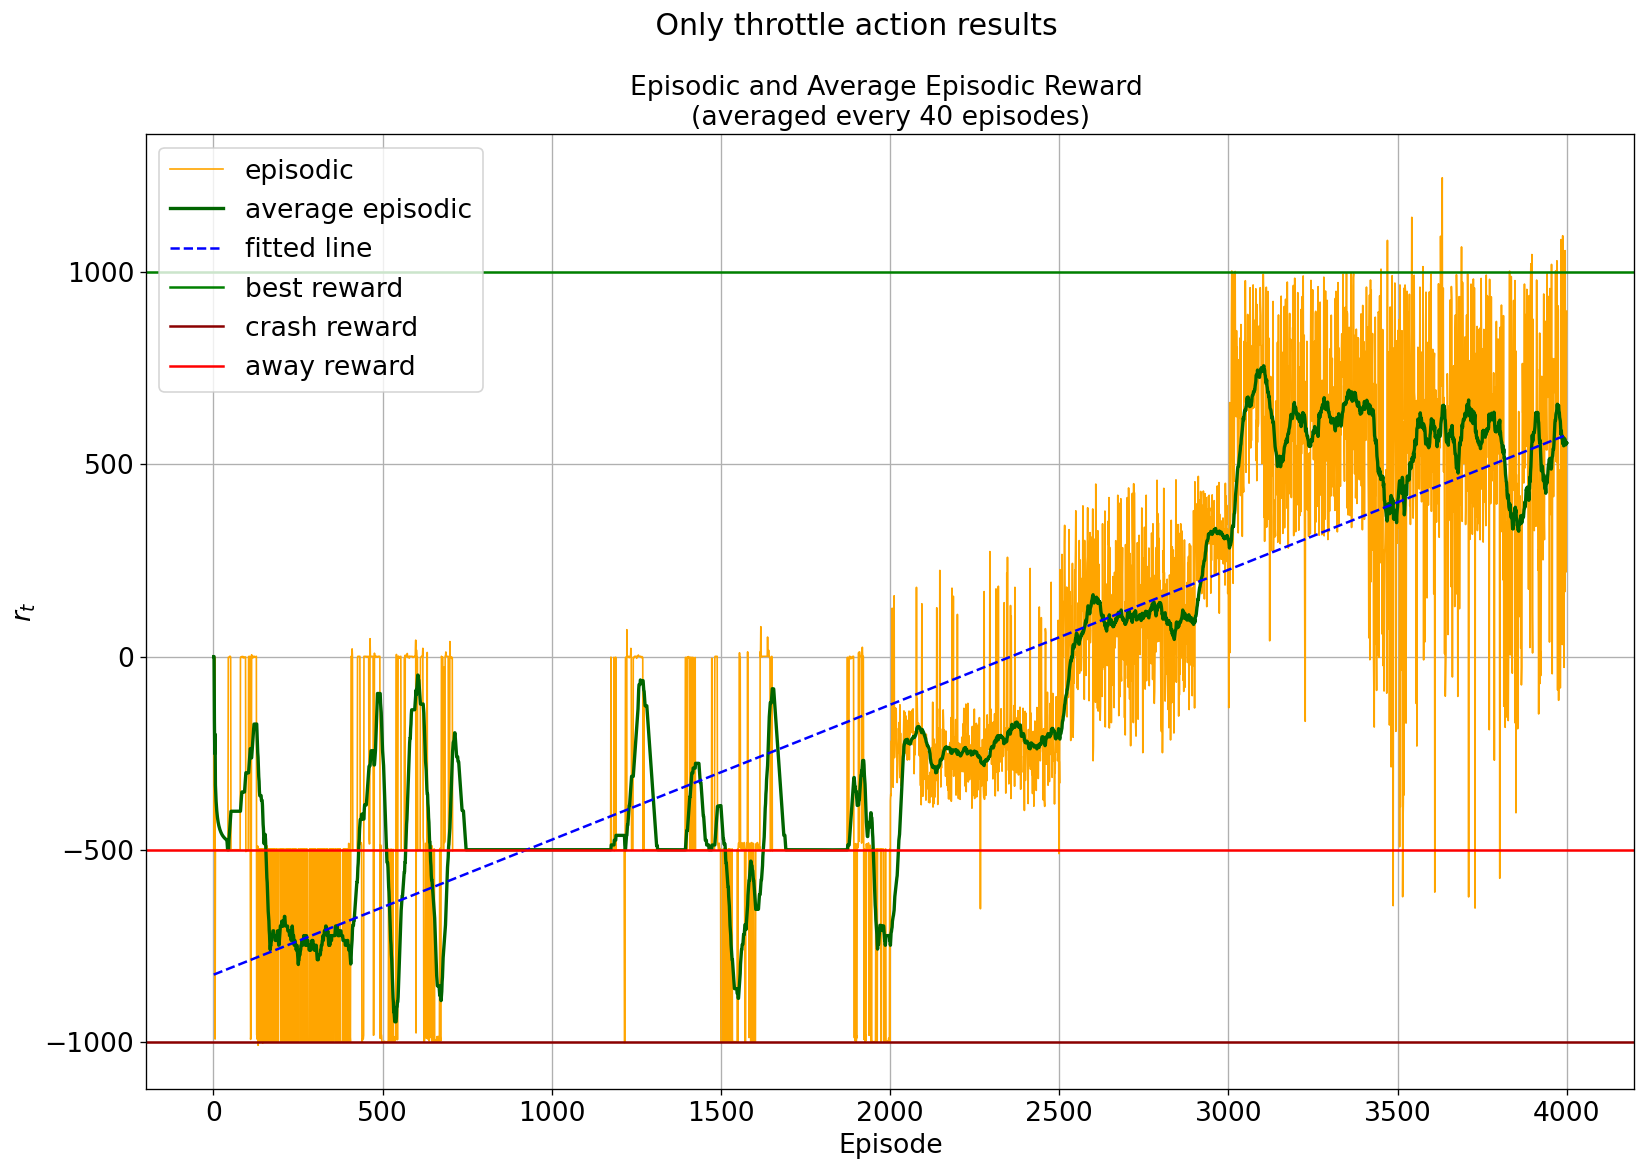

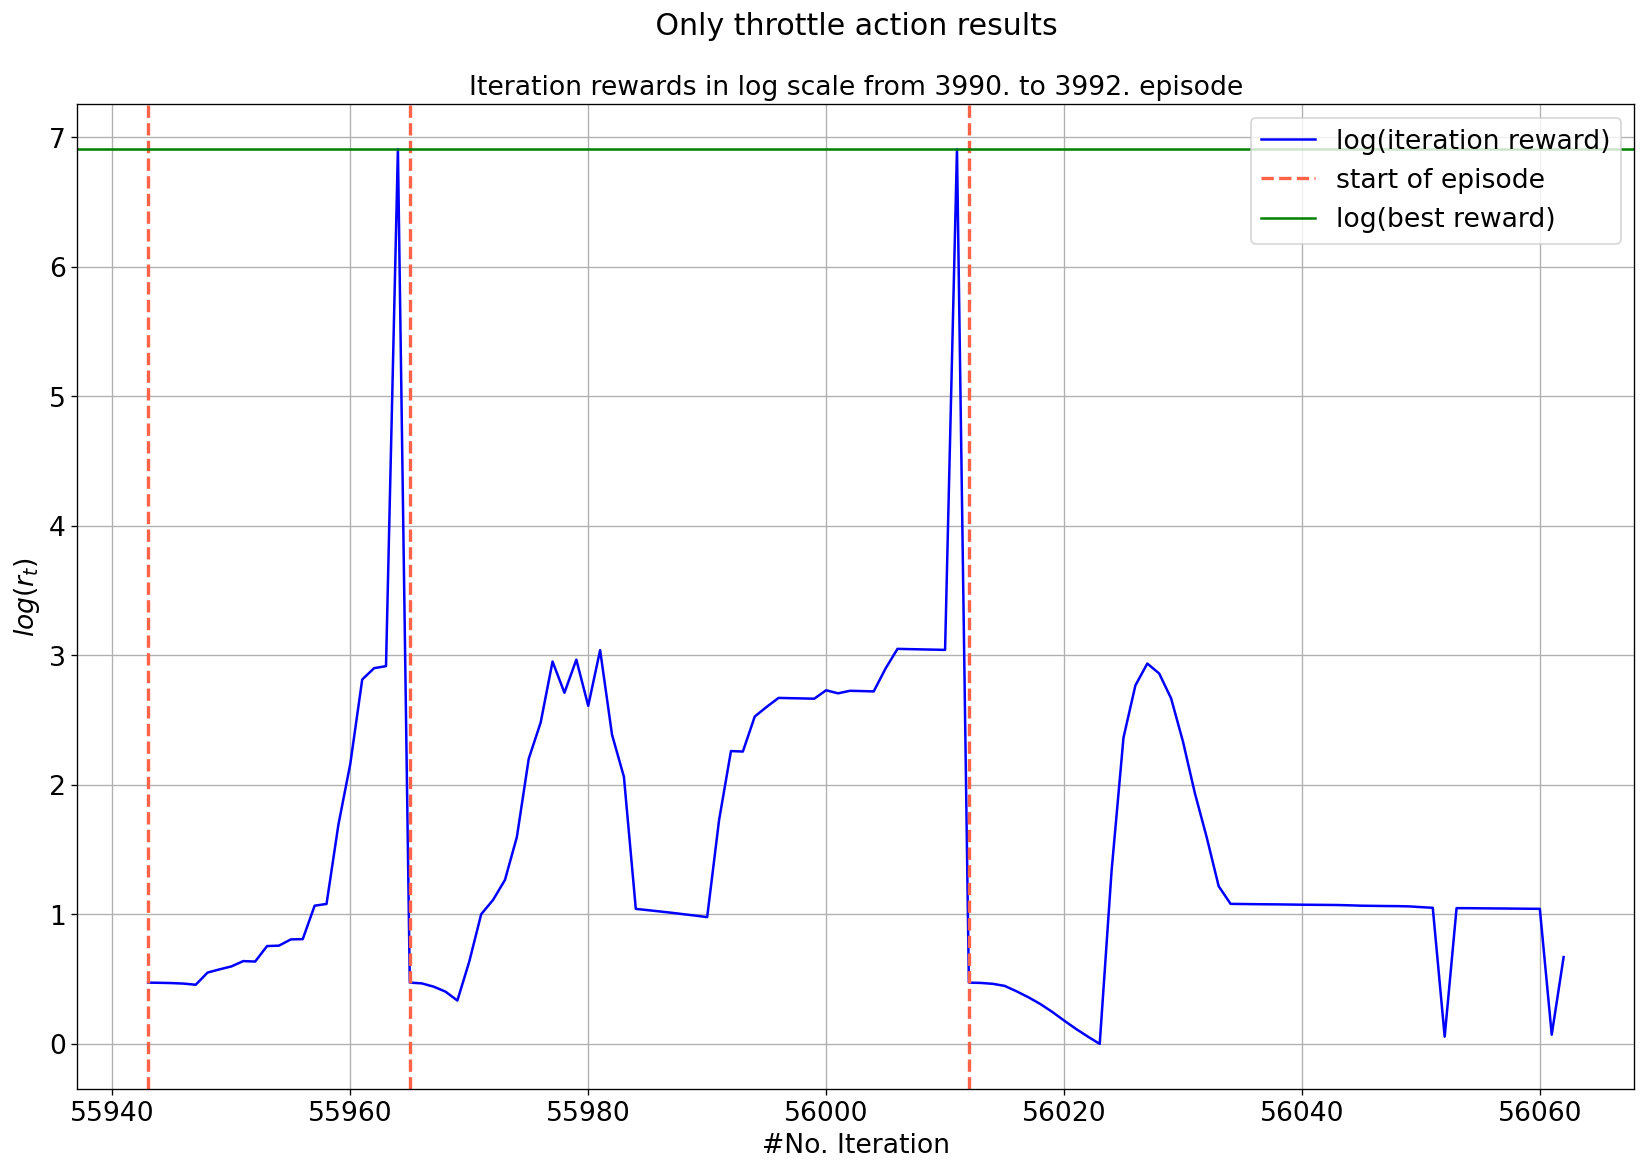

In [8]:
trainings_dict = {
                  '8th_training_1st_only_throttle': 2000,
                  '8th_training_2nd_only_throttle': 1000,
                  '8th_training_3rd_only_throttle': 1000
                 }
    
data_dict = get_data(list(trainings_dict.keys()))
plot_results('8th_training_only_throttle', '       Only throttle action results', data_dict, np.sum(np.array(list(trainings_dict.values()))), left_index=3989, right_index=-9)

## Throttle and steer actions - 9th training results

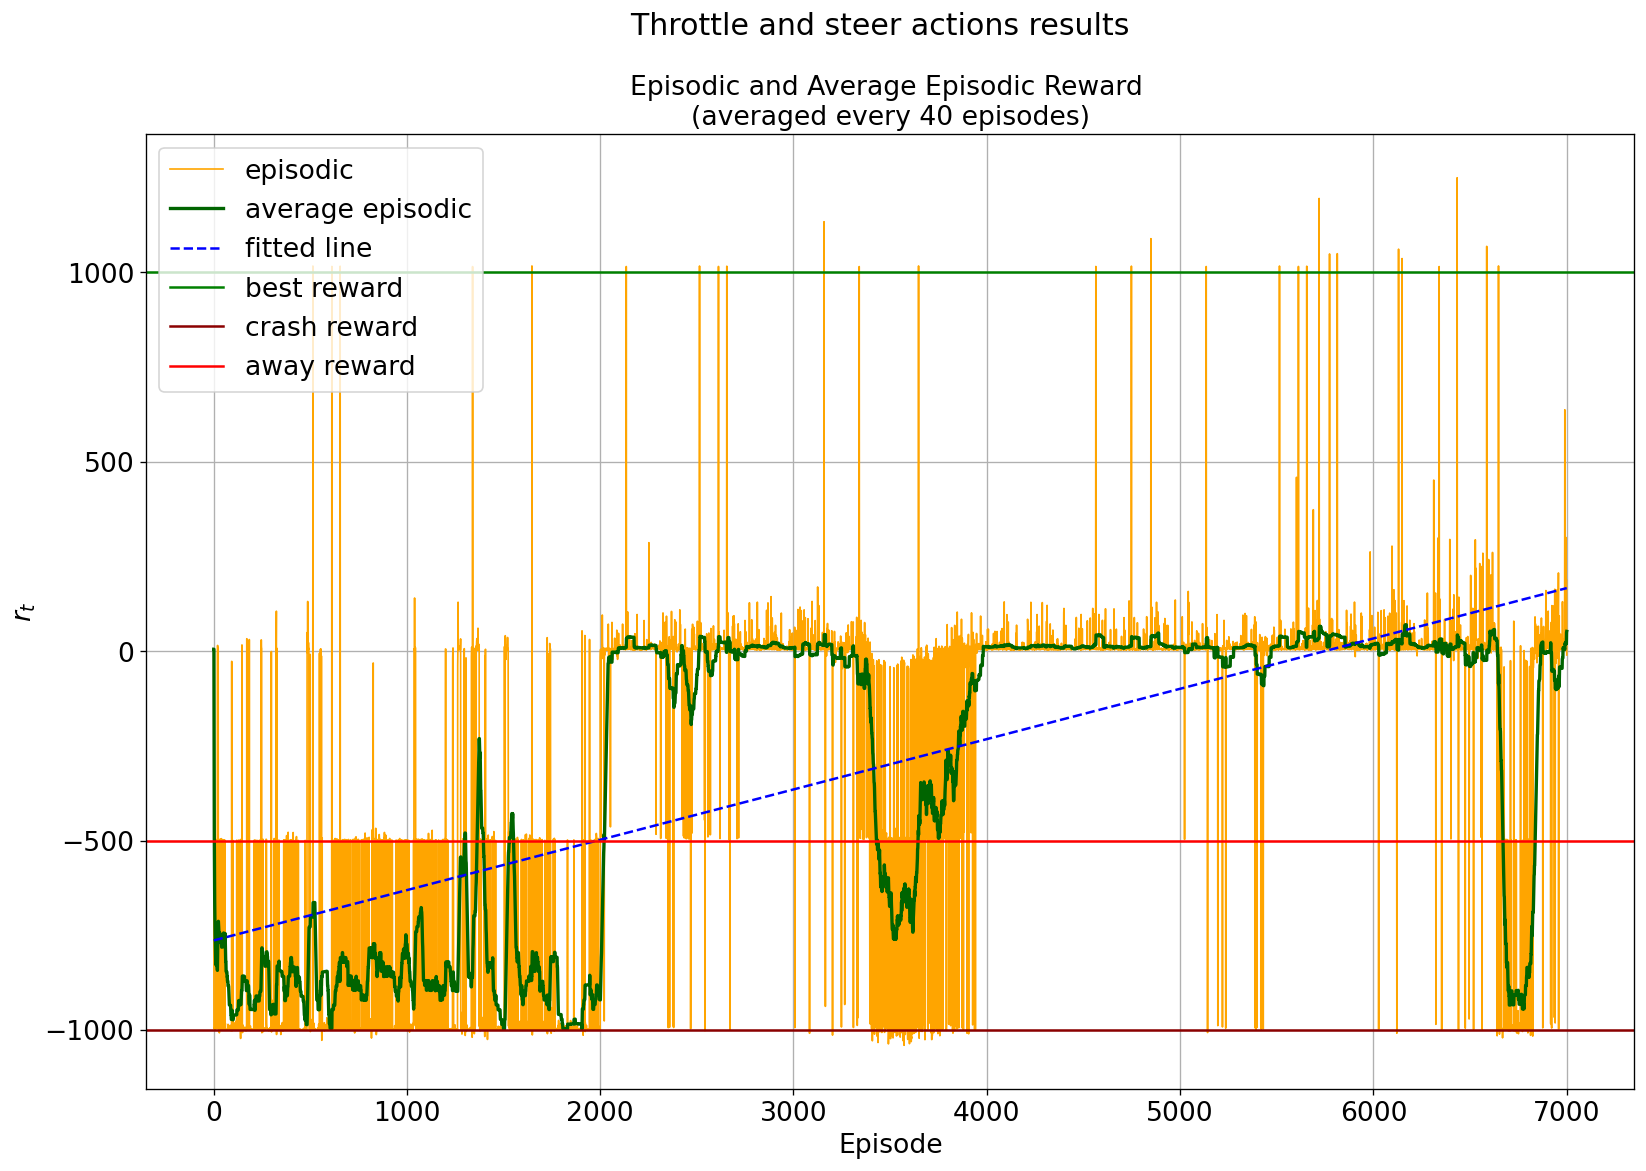

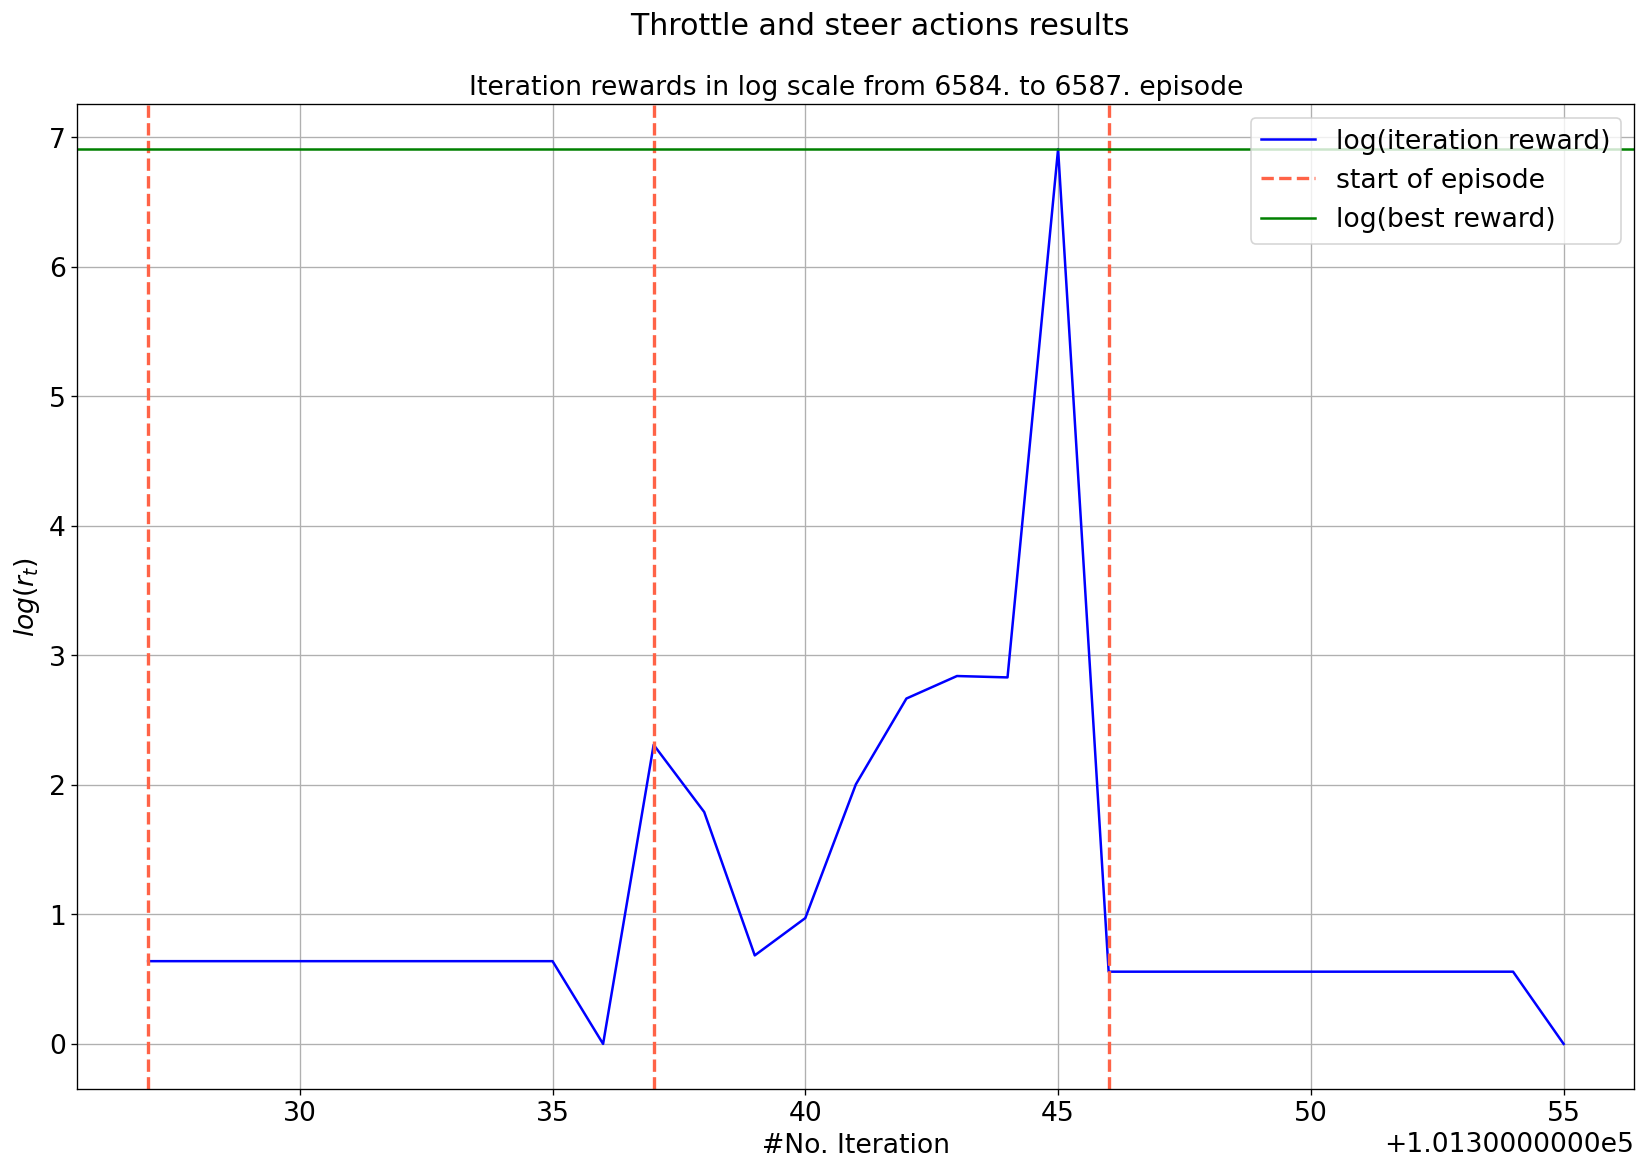

In [9]:
trainings_dict = {
                  '9th_training_1st_throttle_and_steer_random_spawn': 2000,
                  '9th_training_2nd_throttle_and_steer_random_spawn': 3000, 
                  '9th_training_3rd_throttle_and_steer_random_spawn': 2000, 
                 }
    
data_dict = get_data(list(trainings_dict.keys()))
plot_results('9th_training_throttle_and_steer_random_spawn', '            Throttle and steer actions results', data_dict, np.sum(np.array(list(trainings_dict.values()))), left_index=6583, right_index=6586)